In [18]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(100)   
tf.random.set_seed(100)

In [19]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [21]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [22]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [23]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[0:53199] 
Y_train_SS = Y_train_SS[0:53199]
Y_train_V = Y_train_V[0:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 52989
Validation samples: 7570
Testing samples: 15140


In [24]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [25]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [26]:
# Define MLP
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate 
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [27]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           8256        ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 32)           2080        ['dense_8[0][0]']                
                                                                                            

Train on 52989 samples, validate on 7570 samples
Epoch 1/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0283 - dense_12_loss: 0.0218 - dense_13_loss: 0.0065 - dense_12_mse: 0.0218 - dense_13_mse: 0.0065

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.02808, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 103us/sample - loss: 0.0282 - dense_12_loss: 0.0217 - dense_13_loss: 0.0065 - dense_12_mse: 0.0217 - dense_13_mse: 0.0065 - val_loss: 0.0281 - val_dense_12_loss: 0.0208 - val_dense_13_loss: 0.0072 - val_dense_12_mse: 0.0208 - val_dense_13_mse: 0.0072
Epoch 2/100
52544/52989 [============================>.] - ETA: 0s - loss: 0.0121 - dense_12_loss: 0.0089 - dense_13_loss: 0.0032 - dense_12_mse: 0.0089 - dense_13_mse: 0.0032
Epoch 2: val_loss improved from 0.02808 to 0.02387, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 90us/sample - loss: 0.0121 - dense_12_loss: 0.0089 - dense_13_loss: 0.0032 - dense_12_mse: 0.0089 - dense_13_mse: 0.0032 - val_loss: 0.0239 - val_dense_12_loss: 0.0183 - val_dense_13_loss: 0.0056 - val_dense_12_mse: 0.0183 - val_dense_13_mse: 0.0056
Epoch 3/100
52989/52989 [==============================] - ETA: 0s - loss: 0.0110 - dense_12_loss: 0.0081 - dense_13_loss: 0.0030 - dense_12_mse: 0.0081 - dense_13_mse: 0.0030
Epoch 3: val_loss improved from 0.02387 to 0.01945, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 94us/sample - loss: 0.0110 - dense_12_loss: 0.0081 - dense_13_loss: 0.0030 - dense_12_mse: 0.0081 - dense_13_mse: 0.0030 - val_loss: 0.0194 - val_dense_12_loss: 0.0139 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0140 - val_dense_13_mse: 0.0055
Epoch 4/100
52384/52989 [============================>.] - ETA: 0s - loss: 0.0099 - dense_12_loss: 0.0069 - dense_13_loss: 0.0030 - dense_12_mse: 0.0069 - dense_13_mse: 0.0030
Epoch 4: val_loss improved from 0.01945 to 0.01748, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 90us/sample - loss: 0.0099 - dense_12_loss: 0.0069 - dense_13_loss: 0.0030 - dense_12_mse: 0.0069 - dense_13_mse: 0.0030 - val_loss: 0.0175 - val_dense_12_loss: 0.0120 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0120 - val_dense_13_mse: 0.0055
Epoch 5/100
52896/52989 [============================>.] - ETA: 0s - loss: 0.0082 - dense_12_loss: 0.0052 - dense_13_loss: 0.0030 - dense_12_mse: 0.0052 - dense_13_mse: 0.0030
Epoch 5: val_loss improved from 0.01748 to 0.01316, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 91us/sample - loss: 0.0082 - dense_12_loss: 0.0052 - dense_13_loss: 0.0030 - dense_12_mse: 0.0052 - dense_13_mse: 0.0030 - val_loss: 0.0132 - val_dense_12_loss: 0.0076 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0076 - val_dense_13_mse: 0.0055
Epoch 6/100
52352/52989 [============================>.] - ETA: 0s - loss: 0.0072 - dense_12_loss: 0.0042 - dense_13_loss: 0.0029 - dense_12_mse: 0.0042 - dense_13_mse: 0.0029
Epoch 6: val_loss improved from 0.01316 to 0.01265, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 89us/sample - loss: 0.0071 - dense_12_loss: 0.0042 - dense_13_loss: 0.0029 - dense_12_mse: 0.0042 - dense_13_mse: 0.0029 - val_loss: 0.0126 - val_dense_12_loss: 0.0072 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0072 - val_dense_13_mse: 0.0054
Epoch 7/100
52640/52989 [============================>.] - ETA: 0s - loss: 0.0068 - dense_12_loss: 0.0038 - dense_13_loss: 0.0030 - dense_12_mse: 0.0038 - dense_13_mse: 0.0030
Epoch 7: val_loss improved from 0.01265 to 0.01151, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 94us/sample - loss: 0.0068 - dense_12_loss: 0.0038 - dense_13_loss: 0.0029 - dense_12_mse: 0.0038 - dense_13_mse: 0.0029 - val_loss: 0.0115 - val_dense_12_loss: 0.0061 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0061 - val_dense_13_mse: 0.0054
Epoch 8/100
52736/52989 [============================>.] - ETA: 0s - loss: 0.0064 - dense_12_loss: 0.0034 - dense_13_loss: 0.0029 - dense_12_mse: 0.0034 - dense_13_mse: 0.0029
Epoch 8: val_loss improved from 0.01151 to 0.01084, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 88us/sample - loss: 0.0064 - dense_12_loss: 0.0034 - dense_13_loss: 0.0029 - dense_12_mse: 0.0034 - dense_13_mse: 0.0029 - val_loss: 0.0108 - val_dense_12_loss: 0.0053 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0053 - val_dense_13_mse: 0.0055
Epoch 9/100
52736/52989 [============================>.] - ETA: 0s - loss: 0.0061 - dense_12_loss: 0.0032 - dense_13_loss: 0.0029 - dense_12_mse: 0.0032 - dense_13_mse: 0.0029
Epoch 9: val_loss did not improve from 0.01084
52989/52989 [==============================] - 4s 66us/sample - loss: 0.0061 - dense_12_loss: 0.0032 - dense_13_loss: 0.0029 - dense_12_mse: 0.0032 - dense_13_mse: 0.0029 - val_loss: 0.0121 - val_dense_12_loss: 0.0067 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0067 - val_dense_13_mse: 0.0054
Epoch 10/100
52672/52989 [============================>.] - ETA: 0s - loss: 0.0058 - dense_12_loss: 0.0029 - dense_13_loss: 0.0029 - dense_12_mse: 0.0029 - dense_13_mse: 0.0029


52989/52989 [==============================] - 5s 91us/sample - loss: 0.0055 - dense_12_loss: 0.0025 - dense_13_loss: 0.0029 - dense_12_mse: 0.0025 - dense_13_mse: 0.0029 - val_loss: 0.0102 - val_dense_12_loss: 0.0047 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0047 - val_dense_13_mse: 0.0055
Epoch 13/100
52736/52989 [============================>.] - ETA: 0s - loss: 0.0055 - dense_12_loss: 0.0025 - dense_13_loss: 0.0029 - dense_12_mse: 0.0025 - dense_13_mse: 0.0029
Epoch 13: val_loss did not improve from 0.01021
52989/52989 [==============================] - 4s 66us/sample - loss: 0.0055 - dense_12_loss: 0.0025 - dense_13_loss: 0.0029 - dense_12_mse: 0.0025 - dense_13_mse: 0.0029 - val_loss: 0.0109 - val_dense_12_loss: 0.0056 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0056 - val_dense_13_mse: 0.0054
Epoch 14/100
52544/52989 [============================>.] - ETA: 0s - loss: 0.0054 - dense_12_loss: 0.0025 - dense_13_loss: 0.0029 - dense_12_mse: 0.0025 - dense_13_mse: 0.002

52989/52989 [==============================] - 5s 90us/sample - loss: 0.0054 - dense_12_loss: 0.0025 - dense_13_loss: 0.0029 - dense_12_mse: 0.0025 - dense_13_mse: 0.0029 - val_loss: 0.0101 - val_dense_12_loss: 0.0047 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0047 - val_dense_13_mse: 0.0054
Epoch 15/100
52864/52989 [============================>.] - ETA: 0s - loss: 0.0052 - dense_12_loss: 0.0023 - dense_13_loss: 0.0029 - dense_12_mse: 0.0023 - dense_13_mse: 0.0029
Epoch 15: val_loss improved from 0.01010 to 0.00950, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 91us/sample - loss: 0.0052 - dense_12_loss: 0.0023 - dense_13_loss: 0.0029 - dense_12_mse: 0.0023 - dense_13_mse: 0.0029 - val_loss: 0.0095 - val_dense_12_loss: 0.0040 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0040 - val_dense_13_mse: 0.0055
Epoch 16/100
52864/52989 [============================>.] - ETA: 0s - loss: 0.0051 - dense_12_loss: 0.0022 - dense_13_loss: 0.0029 - dense_12_mse: 0.0022 - dense_13_mse: 0.0029
Epoch 16: val_loss did not improve from 0.00950
52989/52989 [==============================] - 4s 67us/sample - loss: 0.0051 - dense_12_loss: 0.0022 - dense_13_loss: 0.0029 - dense_12_mse: 0.0022 - dense_13_mse: 0.0029 - val_loss: 0.0099 - val_dense_12_loss: 0.0044 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0044 - val_dense_13_mse: 0.0054
Epoch 17/100
52608/52989 [============================>.] - ETA: 0s - loss: 0.0051 - dense_12_loss: 0.0022 - dense_13_loss: 0.0029 - dense_12_mse: 0.0022 - dense_13_mse: 0.002

52989/52989 [==============================] - 5s 93us/sample - loss: 0.0050 - dense_12_loss: 0.0021 - dense_13_loss: 0.0029 - dense_12_mse: 0.0021 - dense_13_mse: 0.0029 - val_loss: 0.0092 - val_dense_12_loss: 0.0038 - val_dense_13_loss: 0.0054 - val_dense_12_mse: 0.0038 - val_dense_13_mse: 0.0054
Epoch 19/100
52320/52989 [============================>.] - ETA: 0s - loss: 0.0049 - dense_12_loss: 0.0021 - dense_13_loss: 0.0029 - dense_12_mse: 0.0021 - dense_13_mse: 0.0029
Epoch 19: val_loss improved from 0.00922 to 0.00802, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 89us/sample - loss: 0.0049 - dense_12_loss: 0.0021 - dense_13_loss: 0.0029 - dense_12_mse: 0.0021 - dense_13_mse: 0.0029 - val_loss: 0.0080 - val_dense_12_loss: 0.0038 - val_dense_13_loss: 0.0042 - val_dense_12_mse: 0.0038 - val_dense_13_mse: 0.0042
Epoch 20/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0036 - dense_12_loss: 0.0021 - dense_13_loss: 0.0015 - dense_12_mse: 0.0021 - dense_13_mse: 0.0015
Epoch 20: val_loss improved from 0.00802 to 0.00613, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


52989/52989 [==============================] - 5s 90us/sample - loss: 0.0035 - dense_12_loss: 0.0021 - dense_13_loss: 0.0015 - dense_12_mse: 0.0021 - dense_13_mse: 0.0015 - val_loss: 0.0061 - val_dense_12_loss: 0.0038 - val_dense_13_loss: 0.0024 - val_dense_12_mse: 0.0038 - val_dense_13_mse: 0.0024
Epoch 21/100
52768/52989 [============================>.] - ETA: 0s - loss: 0.0031 - dense_12_loss: 0.0020 - dense_13_loss: 0.0011 - dense_12_mse: 0.0020 - dense_13_mse: 0.0011
Epoch 21: val_loss did not improve from 0.00613
52989/52989 [==============================] - 3s 66us/sample - loss: 0.0031 - dense_12_loss: 0.0020 - dense_13_loss: 0.0011 - dense_12_mse: 0.0020 - dense_13_mse: 0.0011 - val_loss: 0.0068 - val_dense_12_loss: 0.0050 - val_dense_13_loss: 0.0018 - val_dense_12_mse: 0.0050 - val_dense_13_mse: 0.0018
Epoch 22/100
52544/52989 [============================>.] - ETA: 0s - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 0.0011 - dense_12_mse: 0.0021 - dense_13_mse: 0.001

52989/52989 [==============================] - 5s 89us/sample - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 0.0011 - dense_12_mse: 0.0021 - dense_13_mse: 0.0011 - val_loss: 0.0056 - val_dense_12_loss: 0.0042 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0042 - val_dense_13_mse: 0.0015
Epoch 23/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 0.0010 - dense_12_mse: 0.0021 - dense_13_mse: 0.0010
Epoch 23: val_loss did not improve from 0.00565
52989/52989 [==============================] - 4s 66us/sample - loss: 0.0031 - dense_12_loss: 0.0021 - dense_13_loss: 0.0010 - dense_12_mse: 0.0021 - dense_13_mse: 0.0010 - val_loss: 0.0063 - val_dense_12_loss: 0.0042 - val_dense_13_loss: 0.0022 - val_dense_12_mse: 0.0042 - val_dense_13_mse: 0.0022
Epoch 24/100
52352/52989 [============================>.] - ETA: 0s - loss: 0.0029 - dense_12_loss: 0.0020 - dense_13_loss: 9.2808e-04 - dense_12_mse: 0.0020 - dense_13_mse: 9

52989/52989 [==============================] - 5s 94us/sample - loss: 0.0028 - dense_12_loss: 0.0019 - dense_13_loss: 8.8032e-04 - dense_12_mse: 0.0019 - dense_13_mse: 8.8036e-04 - val_loss: 0.0045 - val_dense_12_loss: 0.0034 - val_dense_13_loss: 0.0011 - val_dense_12_mse: 0.0034 - val_dense_13_mse: 0.0011
Epoch 26/100
52160/52989 [============================>.] - ETA: 0s - loss: 0.0028 - dense_12_loss: 0.0019 - dense_13_loss: 8.6279e-04 - dense_12_mse: 0.0019 - dense_13_mse: 8.6279e-04
Epoch 26: val_loss did not improve from 0.00452
52989/52989 [==============================] - 3s 66us/sample - loss: 0.0028 - dense_12_loss: 0.0019 - dense_13_loss: 8.5929e-04 - dense_12_mse: 0.0019 - dense_13_mse: 8.5934e-04 - val_loss: 0.0057 - val_dense_12_loss: 0.0042 - val_dense_13_loss: 0.0015 - val_dense_12_mse: 0.0042 - val_dense_13_mse: 0.0015
Epoch 27/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0027 - dense_12_loss: 0.0019 - dense_13_loss: 8.0368e-04 - dense_12_mse: 

52989/52989 [==============================] - 5s 91us/sample - loss: 0.0023 - dense_12_loss: 0.0017 - dense_13_loss: 6.1657e-04 - dense_12_mse: 0.0017 - dense_13_mse: 6.1659e-04 - val_loss: 0.0044 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 7.9609e-04 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 7.9577e-04
Epoch 37/100
52928/52989 [============================>.] - ETA: 0s - loss: 0.0023 - dense_12_loss: 0.0017 - dense_13_loss: 6.5265e-04 - dense_12_mse: 0.0017 - dense_13_mse: 6.5265e-04
Epoch 37: val_loss did not improve from 0.00441
52989/52989 [==============================] - 4s 67us/sample - loss: 0.0023 - dense_12_loss: 0.0017 - dense_13_loss: 6.5278e-04 - dense_12_mse: 0.0017 - dense_13_mse: 6.5281e-04 - val_loss: 0.0048 - val_dense_12_loss: 0.0034 - val_dense_13_loss: 0.0014 - val_dense_12_mse: 0.0034 - val_dense_13_mse: 0.0014
Epoch 38/100
52512/52989 [============================>.] - ETA: 0s - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 5.8169e-04 - dense_

52989/52989 [==============================] - 5s 90us/sample - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 6.0825e-04 - dense_12_mse: 0.0016 - dense_13_mse: 6.0828e-04 - val_loss: 0.0040 - val_dense_12_loss: 0.0031 - val_dense_13_loss: 8.5833e-04 - val_dense_12_mse: 0.0031 - val_dense_13_mse: 8.5986e-04
Epoch 40/100
52256/52989 [============================>.] - ETA: 0s - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 5.8564e-04 - dense_12_mse: 0.0016 - dense_13_mse: 5.8564e-04
Epoch 40: val_loss did not improve from 0.00396
52989/52989 [==============================] - 4s 66us/sample - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 5.8087e-04 - dense_12_mse: 0.0016 - dense_13_mse: 5.8089e-04 - val_loss: 0.0041 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 7.1886e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 7.0889e-04
Epoch 41/100
52128/52989 [============================>.] - ETA: 0s - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 6.0737e-04 

52989/52989 [==============================] - 5s 88us/sample - loss: 0.0021 - dense_12_loss: 0.0015 - dense_13_loss: 5.4477e-04 - dense_12_mse: 0.0015 - dense_13_mse: 5.4478e-04 - val_loss: 0.0038 - val_dense_12_loss: 0.0030 - val_dense_13_loss: 8.1435e-04 - val_dense_12_mse: 0.0030 - val_dense_13_mse: 8.1365e-04
Epoch 44/100
52896/52989 [============================>.] - ETA: 0s - loss: 0.0020 - dense_12_loss: 0.0015 - dense_13_loss: 5.3595e-04 - dense_12_mse: 0.0015 - dense_13_mse: 5.3595e-04
Epoch 44: val_loss did not improve from 0.00384
52989/52989 [==============================] - 3s 66us/sample - loss: 0.0020 - dense_12_loss: 0.0015 - dense_13_loss: 5.3715e-04 - dense_12_mse: 0.0015 - dense_13_mse: 5.3717e-04 - val_loss: 0.0047 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0012
Epoch 45/100
52192/52989 [============================>.] - ETA: 0s - loss: 0.0021 - dense_12_loss: 0.0016 - dense_13_loss: 5.8132e-04 - dense_

52989/52989 [==============================] - 5s 96us/sample - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 5.0320e-04 - dense_12_mse: 0.0014 - dense_13_mse: 5.0314e-04 - val_loss: 0.0038 - val_dense_12_loss: 0.0032 - val_dense_13_loss: 6.2680e-04 - val_dense_12_mse: 0.0032 - val_dense_13_mse: 6.2512e-04
Epoch 51/100
52480/52989 [============================>.] - ETA: 0s - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 4.8989e-04 - dense_12_mse: 0.0014 - dense_13_mse: 4.8989e-04
Epoch 51: val_loss did not improve from 0.00382
52989/52989 [==============================] - 4s 67us/sample - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 4.8865e-04 - dense_12_mse: 0.0014 - dense_13_mse: 4.8867e-04 - val_loss: 0.0039 - val_dense_12_loss: 0.0032 - val_dense_13_loss: 6.5953e-04 - val_dense_12_mse: 0.0032 - val_dense_13_mse: 6.5944e-04
Epoch 52/100
52896/52989 [============================>.] - ETA: 0s - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 5.0689e-04 

52989/52989 [==============================] - 5s 90us/sample - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 5.0706e-04 - dense_12_mse: 0.0014 - dense_13_mse: 5.0708e-04 - val_loss: 0.0038 - val_dense_12_loss: 0.0031 - val_dense_13_loss: 6.6077e-04 - val_dense_12_mse: 0.0031 - val_dense_13_mse: 6.6063e-04
Epoch 53/100
52832/52989 [============================>.] - ETA: 0s - loss: 0.0020 - dense_12_loss: 0.0014 - dense_13_loss: 5.3454e-04 - dense_12_mse: 0.0014 - dense_13_mse: 5.3454e-04
Epoch 53: val_loss did not improve from 0.00376
52989/52989 [==============================] - 4s 68us/sample - loss: 0.0020 - dense_12_loss: 0.0014 - dense_13_loss: 5.3325e-04 - dense_12_mse: 0.0014 - dense_13_mse: 5.3328e-04 - val_loss: 0.0042 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 9.0520e-04 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 9.0192e-04
Epoch 54/100
52960/52989 [============================>.] - ETA: 0s - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 5.0969e-04 

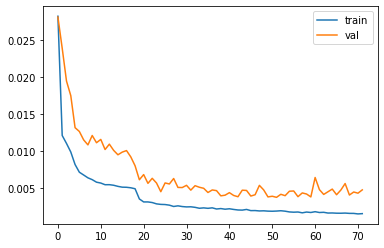

---Training time: 286.61771154 seconds ---


In [28]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto') 
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [29]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.95649, Train (V) - 0.90718
R2 scores: Validation (SS) - 0.90161, Validation (V) - 0.83965
R2 scores: Testing (SS) - 0.79565, Testing (V) - 0.68347
RMSE scores: Train (SS) - 0.03107, Train (V) - 0.01656
RMSE scores: Validation (SS) - 0.06229, Validation (V) - 0.02979
RMSE scores: Testing (SS) - 0.09730, Testing (V) - 0.04799


In [30]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [31]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

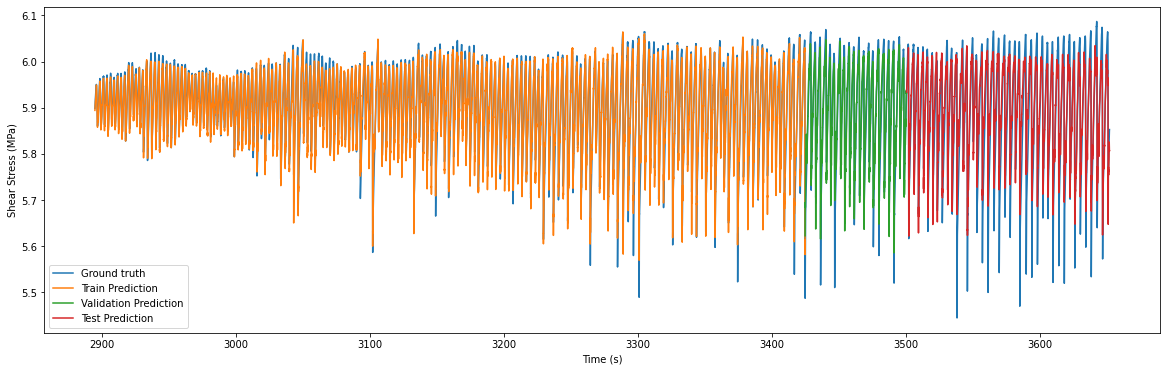

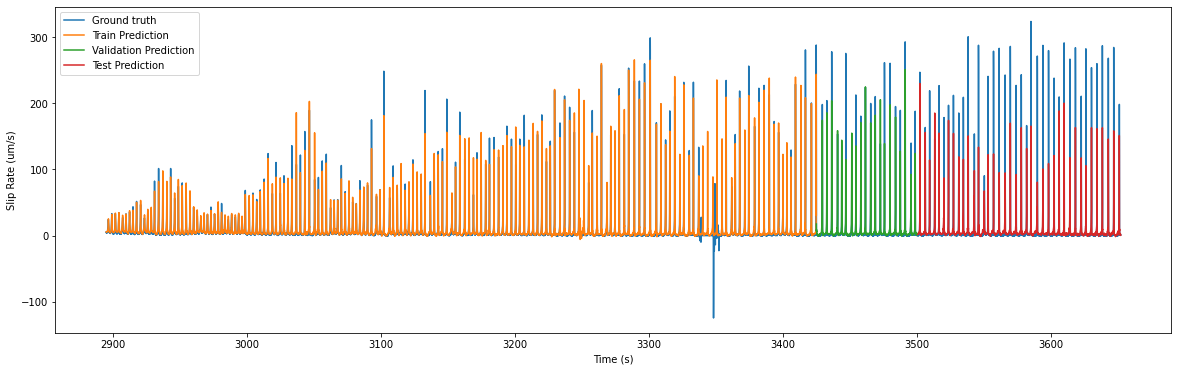

In [32]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[0:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

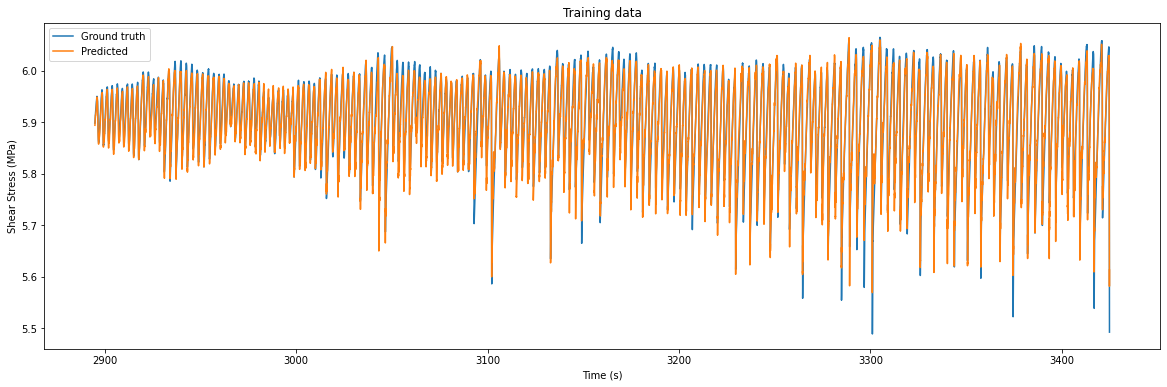

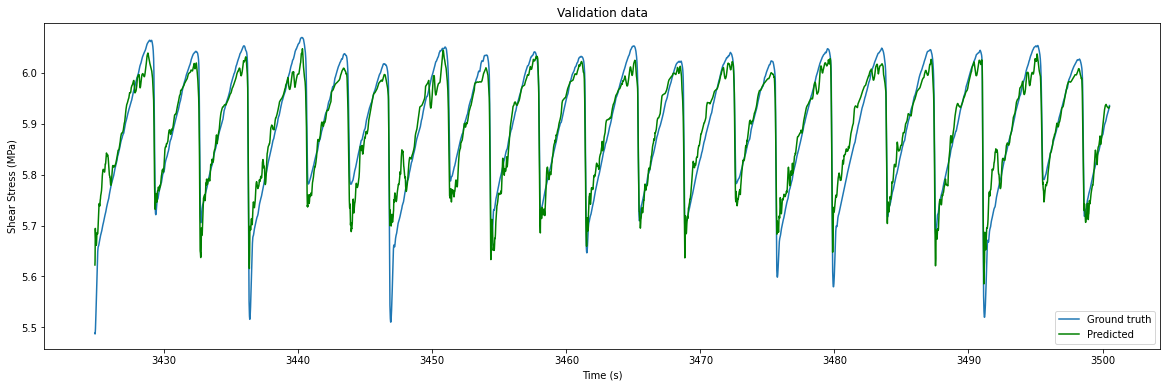

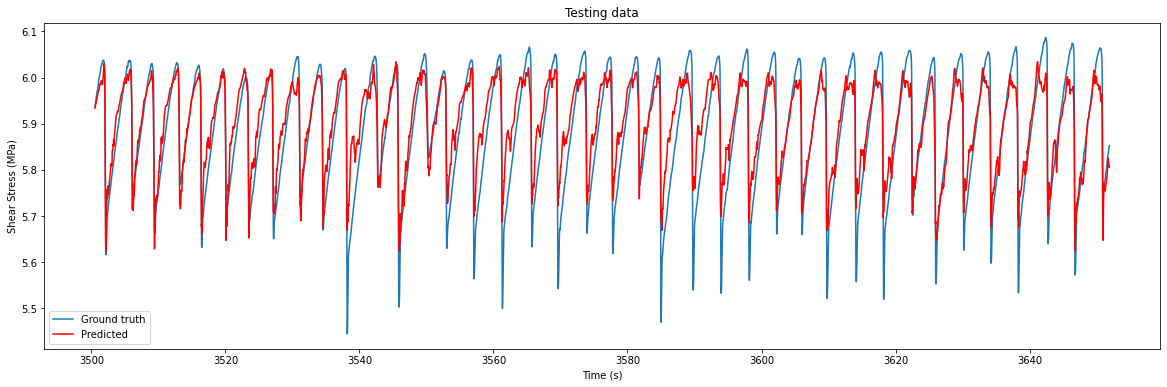

In [33]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

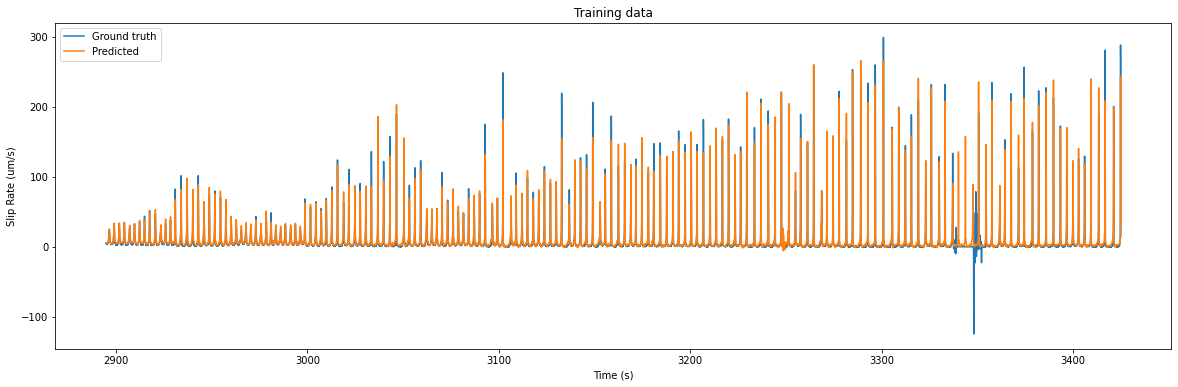

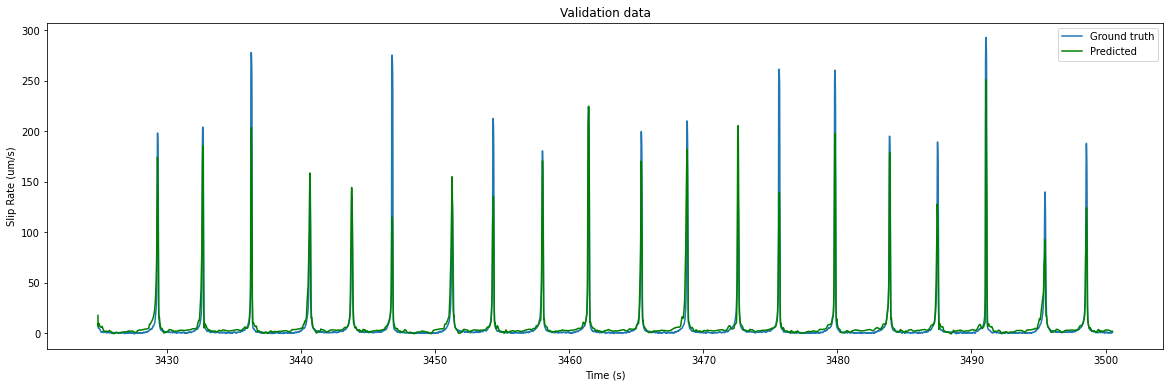

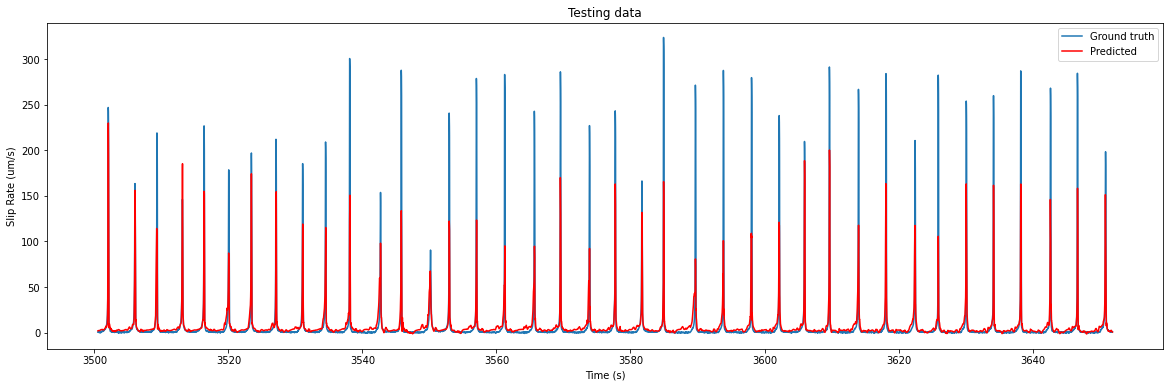

In [34]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')